In [4]:
!pip install onnx
!pip install onnxruntime
!pip install torchaudio

     |████████████████████████████████| 12.7 MB 82 kB/s 
     |████████████████████████████████| 4.8 MB 3.1 MB/s 
     |████████████████████████████████| 2.9 MB 3.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x56075eb2c000 @  0x7f2e477a4615 0x560725d094cc 0x560725de947a 0x560725d0c2ed 0x560725dfde1d 0x560725d7fe99 0x560725d7a9ee 0x560725d0dbda 0x560725d7fd00 0x560725d7a9ee 0x560725d0dbda 0x560725d7c737 0x560725dfec66 0x560725d7bdaf 0x560725dfec66 0x560725d7bdaf 0x560725dfec66 0x560725d7bdaf 0x560725d0e039 0x560725d51409 0x560725d0cc52 0x560725d7fc25 0x560725d7a9ee 0x560725d0dbda 0x560725d7c737 0x560725d7a9ee 0x560725d0dbda 0x560725d7b915 0x560725d0dafa 0x560725d7bc0d 0x560725d7a9ee
     |████████████████████████████████| 881.9 MB 16 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip'

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10yma2Vz97J9G5oL5oR9gNZwZBSyWEiqF' -O keyword-spotting.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KHYpbQwxdgHeG829VywA-UEybqyj2cSE' -O keyword-spotting.pt

--2021-11-02 20:18:24--  https://docs.google.com/uc?export=download&id=10yma2Vz97J9G5oL5oR9gNZwZBSyWEiqF
Resolving docs.google.com (docs.google.com)... 173.194.216.113, 173.194.216.100, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vkup6enggudcro776pr5djnbmeklavgb/1635884250000/08668581034794593522/*/10yma2Vz97J9G5oL5oR9gNZwZBSyWEiqF?e=download [following]
--2021-11-02 20:18:25--  https://doc-0s-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vkup6enggudcro776pr5djnbmeklavgb/1635884250000/08668581034794593522/*/10yma2Vz97J9G5oL5oR9gNZwZBSyWEiqF?e=download
Resolving doc-0s-8c-docs.googleusercontent.com (doc-0s-8c-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0s-8c-docs.googleusercontent.com (doc-0s-

In [9]:
import IPython
import soundfile as sf

import torch

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import onnx
import onnxruntime

import torchaudio

In [31]:
# Code for recording audio from the browser
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('audio.wav','wb+') as f:
        f.write(b)
    return 'audio.wav'

#### Pytorch model

In [14]:
audio_transforms = nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'hop_length': 16 * 10,
                                                                        "center": True, 'n_mels': 64}),
    torchaudio.transforms.SlidingWindowCmn(cmn_window=600, norm_vars=True, center=True)
)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

#### Onnx model

In [15]:
device = 'cpu'
if device == 'cuda':
    providers = ['CUDAExecutionProvider']
else:
    providers = ['CPUExecutionProvider']
ort_session = onnxruntime.InferenceSession('keyword-spotting.onnx', providers=providers)

In [80]:
def predict_onnx(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)
    waveform = np.pad(waveform, (0, 8000), 'constant', constant_values=0)
    waveform = waveform[:16000*5].reshape(5, -1)

    
    features = audio_transforms(torch.from_numpy(waveform).float()).reshape(5, -1, 40)
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(features)}
    ort_outs = ort_session.run(None, ort_inputs)
    pred = ort_outs[0]
    
    output = pred.argmax(1)
    return output

In [84]:
import seaborn as sns

def plot_signal(sr, signal, signal_id, predict, labels=['silent', 'unk', 'down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']):
#     logger.info(
#         f"Sampling rate = {sr} | Num. points = {len(signal)} | Tot. duration = {len(signal) / sr:.2f} s"
#     )
    plt.figure(figsize=(15, 10))
    sns.set()
    sns.lineplot(x=[i / sr for i in range(len(signal))], y=signal)
    colors = ['white', 'red', 'blue', 'green', 'yellow', 'gray', 'olive', 'teal', 'violet', 'pink', 'bisque', 'orange']

    start, end = 0, 1
    for pred in predict:
        label = labels[pred]
        color = colors[pred]
        plt.axvspan(start, end, alpha=0.5, color=color, label=label)
        plt.legend()
        start, end = start + 1, end + 1


    plt.title(f"Sample number {signal_id} ", size=20)
    plt.xlabel("Time (s)", size=20)
    plt.ylabel("Amplitude", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

In [32]:

# Now recording for 5 seconds, say what you will..
InvokeButton('Start recording', record)

<IPython.core.display.Javascript object>

In [33]:
import IPython
IPython.display.Audio('audio.wav', rate = 16000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


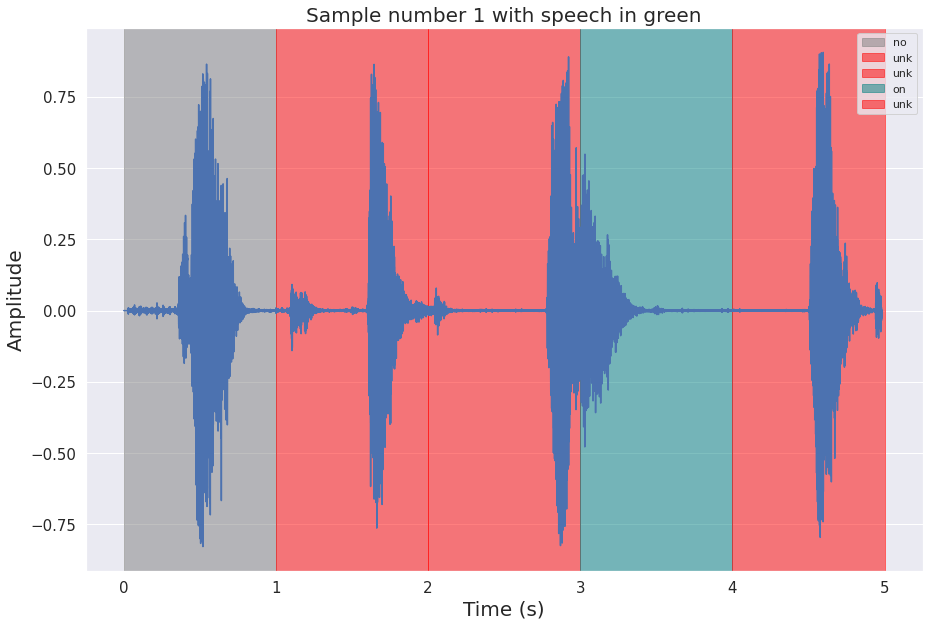

In [85]:
pred = predict_onnx('audio.wav')

signal, samplerate = librosa.load('audio.wav', sr=16000)
plot_signal(samplerate, signal, 1, pred)